 
Data Extracted from the census bureau database found at ​http://www.census.gov/ftp/pub/DES/www/welcome.
html Donor: Ronny Kohavi and Barry Becker, Data Mining and Visualization

Prediction task is to determine whether a person makes over 50K a year. Conversion of original data as follows:

Discretized a gross income into two ranges with threshold 50,000. 2. Convert U.S. to US to avoid periods.
Convert Unknown to "?"
Run MLC++ GenCVFiles to generate data,test. Description of fnlwgt (final weight) The weights on the CPS files are controlled 
to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population
Division here at the Census Bureau. We use 3 sets of controls.
These are:

A single cell estimate of the population 16+ for each state.
Controls for Hispanic Origin by age and sex.
Controls by Race, age and sex. We use all three sets of controls in our weighting program and "rake" through them 6 times 
so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from 
CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. 
People with similar demographic characteristics should have similar weights. There is one important caveat
to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, 
each with its own probability of selection, the statement only applies within state.
Problem 1: Prediction task is to determine whether a person makes over 50K a year.
Problem 2: Which factors are important Problem.
3: Which algorithms are best for this dataset

In [3]:
# Import the required modules for the data study, analysis and prediction.
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, tree
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Get the training and test datasets from the source

train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)

In [7]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [10]:
train_set.shape

(32561, 15)

In [12]:
test_set.shape

(16281, 15)

In [14]:
 #There is no column name for the data. So add column names based on the description.

cols=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
     'race','sex','capital-gain','capital-loss','hours-per-week','native-country','salaryclass']
train_set.columns=cols
train_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salaryclass
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [15]:
# Set the column names to the test dataset

test_set.columns=cols
test_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salaryclass
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [16]:
# Check if there are any null values in the train dataset

train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
salaryclass       32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [17]:
# Check if there are any null values in the train dataset

test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education-num     16281 non-null int64
marital-status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital-gain      16281 non-null int64
capital-loss      16281 non-null int64
hours-per-week    16281 non-null int64
native-country    16281 non-null object
salaryclass       16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [19]:
# There are no nulls in the data, but data with ' ?'. Replace them with Nulls and remove the rows. 

train_new=train_set.replace(' ?', np.nan).dropna()
test_new=test_set.replace(' ?',np.nan).dropna()

# There is a difference between the train salary category and test salary category. Change them to be the same. 
test_new['salaryclass']=test_new.salaryclass.replace({' <=50K.':' <=50K',' >50K.':' >50K'})
test_new.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salaryclass
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


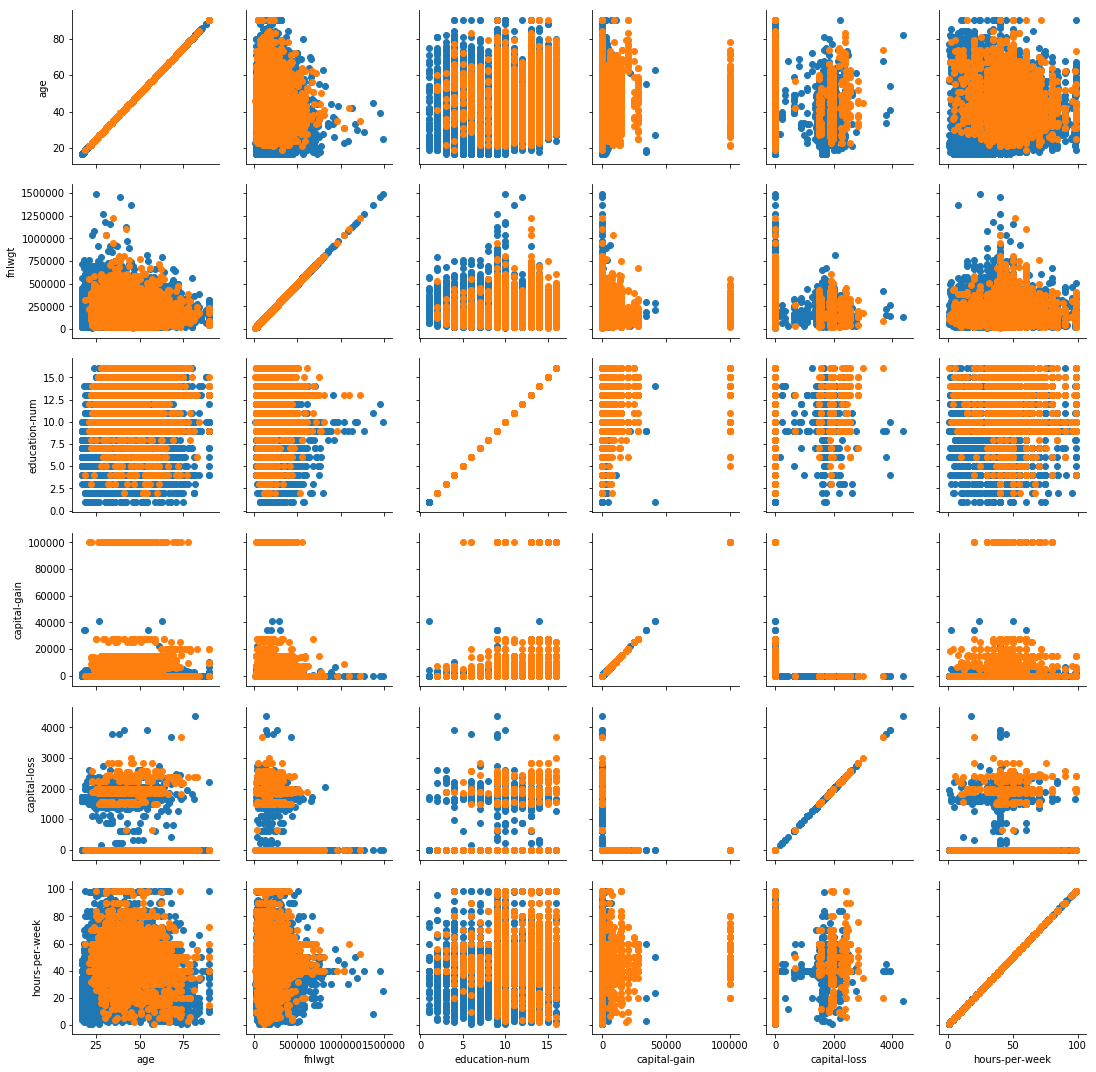

In [20]:
#Creating a scatter plots for all pairs of variables of train_set. 
pg = sns.PairGrid(data=train_new, hue='salaryclass')
pg.map(plt.scatter)

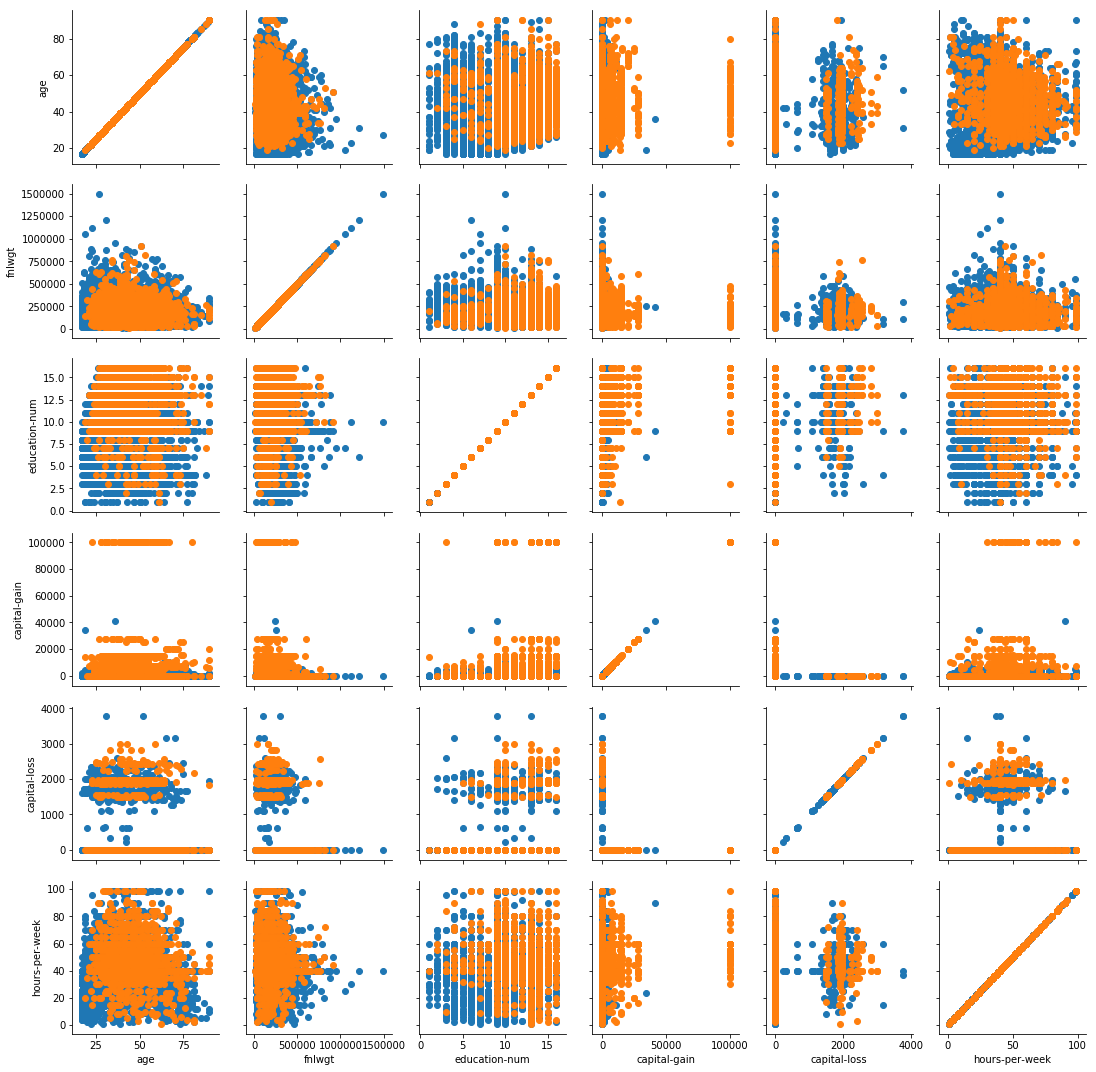

In [21]:
#Creating a scatter plots for all pairs of variables of test_set.
pg = sns.PairGrid(data=test_new, hue='salaryclass')
pg.map(plt.scatter)

In [22]:

# Change the non numerical values to categorical values for prediction

for attrb in train_new.columns:
    if train_new[attrb].dtype=='object':
        train_new[attrb]=pd.Categorical(train_new[attrb]).codes
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
age               30162 non-null int64
workclass         30162 non-null int8
fnlwgt            30162 non-null int64
education         30162 non-null int8
education-num     30162 non-null int64
marital-status    30162 non-null int8
occupation        30162 non-null int8
relationship      30162 non-null int8
race              30162 non-null int8
sex               30162 non-null int8
capital-gain      30162 non-null int64
capital-loss      30162 non-null int64
hours-per-week    30162 non-null int64
native-country    30162 non-null int8
salaryclass       30162 non-null int8
dtypes: int64(6), int8(9)
memory usage: 1.9 MB


In [23]:
# Change the non numerical values to categorical values for the test dataset as well. 

for attrb in test_new.columns:
    if test_new[attrb].dtype=='object':
        test_new[attrb]=pd.Categorical(test_new[attrb]).codes
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15060 entries, 0 to 16280
Data columns (total 15 columns):
age               15060 non-null int64
workclass         15060 non-null int8
fnlwgt            15060 non-null int64
education         15060 non-null int8
education-num     15060 non-null int64
marital-status    15060 non-null int8
occupation        15060 non-null int8
relationship      15060 non-null int8
race              15060 non-null int8
sex               15060 non-null int8
capital-gain      15060 non-null int64
capital-loss      15060 non-null int64
hours-per-week    15060 non-null int64
native-country    15060 non-null int8
salaryclass       15060 non-null int8
dtypes: int64(6), int8(9)
memory usage: 956.0 KB


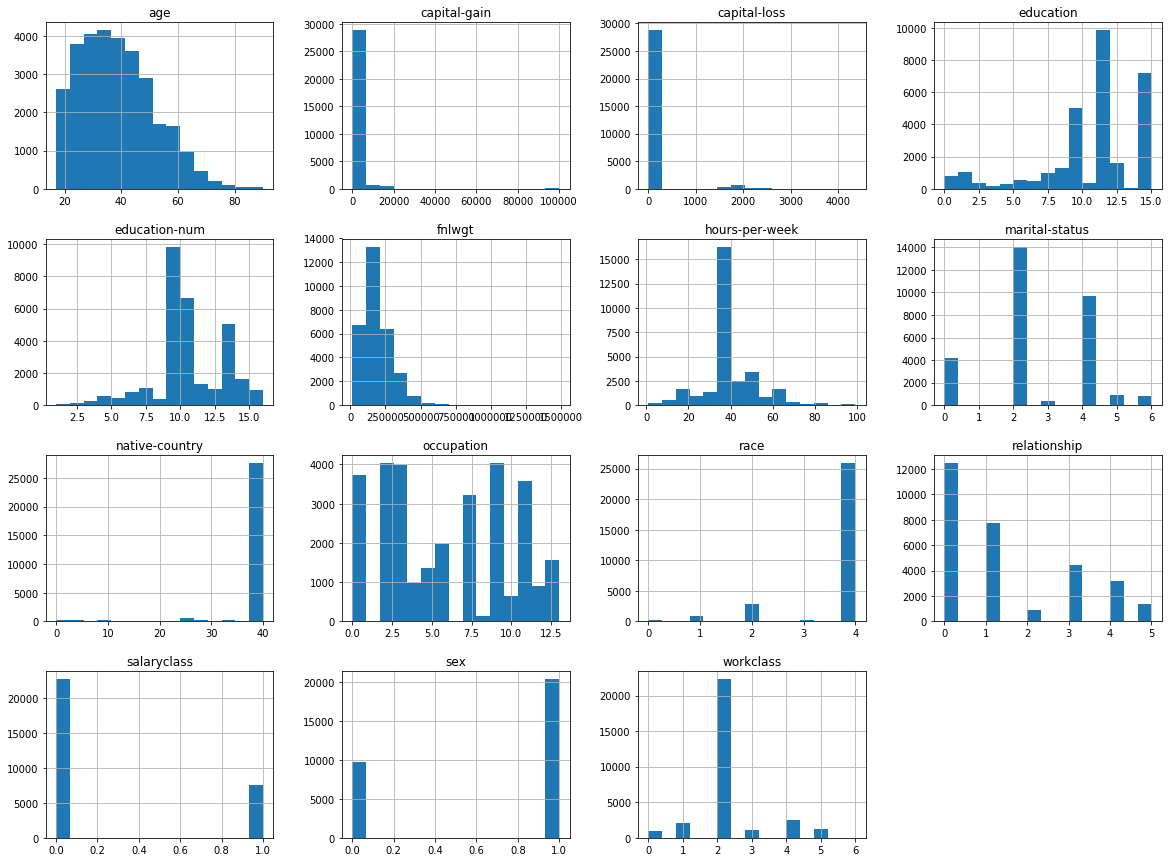

In [25]:
# Show the distribution of the different parameters in the dataset

train_new.hist(bins=15,figsize=(20,15))
plt.show()

In [26]:
# Show the distriution of people in the two salaryclass categories
train_new['salaryclass'].value_counts()

0    22654
1     7508
Name: salaryclass, dtype: int64

                     age  workclass    fnlwgt  education  education-num  \
age             1.000000   0.080540 -0.076511  -0.001111       0.043526   
workclass       0.080540   1.000000 -0.032493   0.017855       0.037833   
fnlwgt         -0.076511  -0.032493  1.000000  -0.027102      -0.044992   
education      -0.001111   0.017855 -0.027102   1.000000       0.345410   
education-num   0.043526   0.037833 -0.044992   0.345410       1.000000   
marital-status -0.276373  -0.034241  0.032163  -0.040664      -0.063419   
occupation     -0.005682   0.015572  0.000204  -0.038212       0.087717   
relationship   -0.246456  -0.067417  0.009298  -0.012717      -0.091935   
race            0.023374   0.044731 -0.023895   0.011154       0.032805   
sex             0.081993   0.074973  0.025362  -0.027888       0.006157   
capital-gain    0.080154   0.035350  0.000422   0.030575       0.124416   
capital-loss    0.060165   0.007204 -0.009750   0.015028       0.079646   
hours-per-week  0.101599 

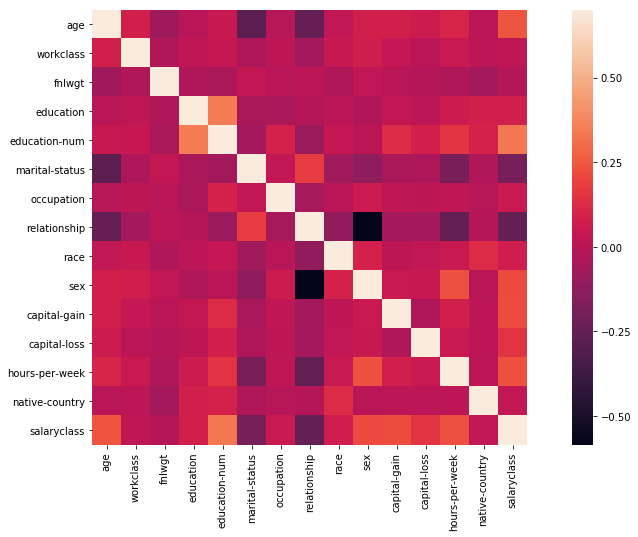

In [27]:
# Check the correlation between the different attributes. 

matrix = train_new.corr()
print(matrix)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(matrix, vmax=0.7, square=True)

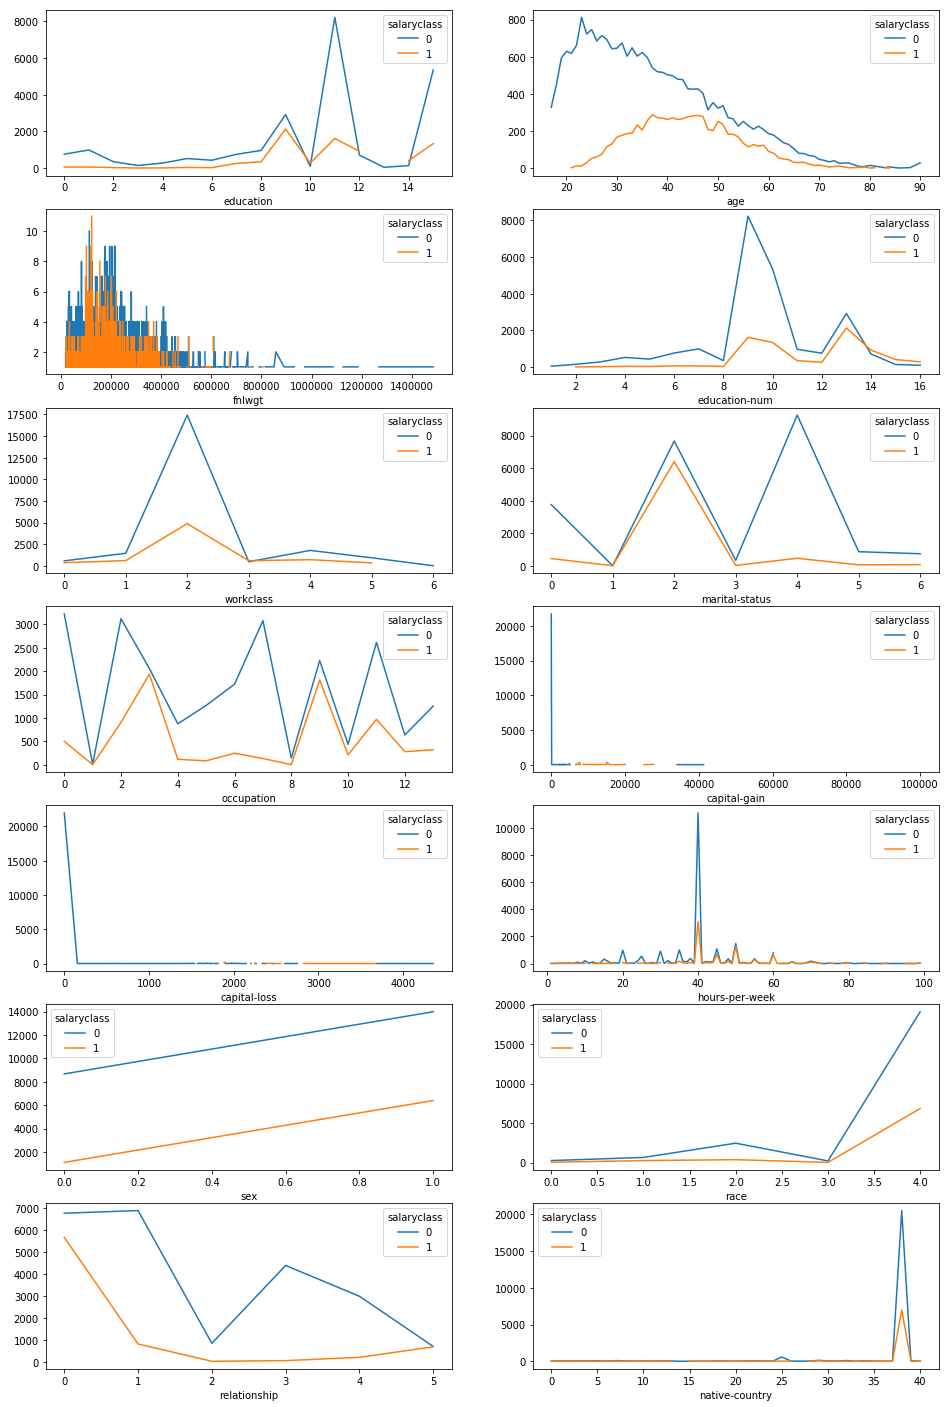

In [28]:
# Plots to see the relationship of the different parameters to the salaryclass.

fig, ax = plt.subplots(7,2,sharey=False)
edugrp=train_new.groupby(['education'])['salaryclass'].value_counts()
agegrp=train_new.groupby(['age'])['salaryclass'].value_counts()
fnlwgtgrp=train_new.groupby(['fnlwgt'])['salaryclass'].value_counts()
edunumgrp=train_new.groupby(['education-num'])['salaryclass'].value_counts()
workclsgrp=train_new.groupby(['workclass'])['salaryclass'].value_counts()
marstatgrp=train_new.groupby(['marital-status'])['salaryclass'].value_counts()
occugrp=train_new.groupby(['occupation'])['salaryclass'].value_counts()
capgaingrp=train_new.groupby(['capital-gain'])['salaryclass'].value_counts()
caplossgrp=train_new.groupby(['capital-loss'])['salaryclass'].value_counts()
hrperwkgrp=train_new.groupby(['hours-per-week'])['salaryclass'].value_counts()
gendergrp=train_new.groupby(['sex'])['salaryclass'].value_counts()
racegrp=train_new.groupby(['race'])['salaryclass'].value_counts()
reltngrp=train_new.groupby(['relationship'])['salaryclass'].value_counts()
cntrygrp=train_new.groupby(['native-country'])['salaryclass'].value_counts()

edugrp.unstack().plot(ax=ax[0][0],figsize=(16,25))
agegrp.unstack().plot(ax=ax[0][1])
fnlwgtgrp.unstack().plot(ax=ax[1][0])
edunumgrp.unstack().plot(ax=ax[1][1])
workclsgrp.unstack().plot(ax=ax[2][0])
marstatgrp.unstack().plot(ax=ax[2][1])
occugrp.unstack().plot(ax=ax[3][0])
capgaingrp.unstack().plot(ax=ax[3][1])
caplossgrp.unstack().plot(ax=ax[4][0])
hrperwkgrp.unstack().plot(ax=ax[4][1])
gendergrp.unstack().plot(ax=ax[5][0])
racegrp.unstack().plot(ax=ax[5][1])
reltngrp.unstack().plot(ax=ax[6][0])
cntrygrp.unstack().plot(ax=ax[6][1])

In [29]:
# Take the target variable salary out of the data. 

y_train = train_new.pop('salaryclass')
y_test = test_new.pop('salaryclass')

In [30]:
# Remove the fields that are not important from the dataframe for predictions

train_new.drop(['fnlwgt','education','workclass','native-country'],axis=1,inplace=True)
test_new.drop(['fnlwgt','education','workclass','native-country'],axis=1,inplace=True)

In [31]:
train_new.columns

Index(['age', 'education-num', 'marital-status', 'occupation', 'relationship',
       'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week'],
      dtype='object')

In [32]:
# Algorithm 1 - Logistic Regression Model.
# Instantiate a logistic regression model, and fit with X and y

logmodel = LogisticRegression()
logmodel.fit(train_new, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
# Use the model to predict for the test dataset

logpredict = logmodel.predict(test_new)
logpredict

array([0, 0, 0, ..., 0, 1, 1], dtype=int8)

In [34]:
# Accuracy of the model

print('Accuracy of the Logistic Regression model : ', metrics.accuracy_score(y_test, logpredict))

Accuracy of the Logistic Regression model :  0.8184594953519256


In [35]:
# Print the confusion matrix and the classification report for the model
print(metrics.confusion_matrix(y_test, logpredict))
print(metrics.classification_report(y_test, logpredict))

[[10702   658]
 [ 2076  1624]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     11360
           1       0.71      0.44      0.54      3700

   micro avg       0.82      0.82      0.82     15060
   macro avg       0.77      0.69      0.71     15060
weighted avg       0.81      0.82      0.80     15060



In [36]:
# Evaluate the model using 10-fold cross-validation

logscores = cross_val_score(LogisticRegression(), train_new, y_train, scoring='accuracy', cv=10)
logscores, logscores.mean()

(array([0.81504806, 0.82134571, 0.82035134, 0.81670534, 0.81929708,
        0.82625995, 0.81366048, 0.82692308, 0.82321725, 0.82189055]),
 0.8204698825380271)

In [37]:
# Algorithm 2 - Decision Tree
# Train the decision tree

dtree = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
dtree.fit(train_new, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [38]:
# Use the model to make predictions with the test data
    
dtpred = dtree.predict(test_new)

In [39]:
# Check the performance of the model
count_misclassified = (y_test != dtpred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
dtaccuracy = metrics.accuracy_score(y_test, dtpred)
print('Accuracy of the Decision Tree model : ', dtaccuracy)

Misclassified samples: 2283
Accuracy of the Decision Tree model :  0.8484063745019921


In [40]:
# Print the confusion matrix and the classification report for the model
print(metrics.confusion_matrix(y_test, dtpred))
print(metrics.classification_report(y_test, dtpred))

[[10730   630]
 [ 1653  2047]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     11360
           1       0.76      0.55      0.64      3700

   micro avg       0.85      0.85      0.85     15060
   macro avg       0.82      0.75      0.77     15060
weighted avg       0.84      0.85      0.84     15060



In [41]:
# Evaluate the model using 10-fold cross-validation

dtscores = cross_val_score(DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0), 
                           train_new, y_train, scoring='accuracy', cv=10)
dtscores, dtscores.mean()

(array([0.83824992, 0.85117667, 0.85150812, 0.84918794, 0.8494695 ,
        0.8551061 , 0.85477454, 0.85941645, 0.85638474, 0.84477612]),
 0.851005007898673)

In [42]:

# Algorithm 3 - RandomForest Classifier
# Create Randomforest classifier model

rfmodel = RandomForestClassifier(n_estimators=100)
rfmodel.fit(train_new, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
rfpred = rfmodel.predict(test_new)

rfaccuracy_score = metrics.accuracy_score(y_test,rfpred)
print('Accuracy of the Random Forest Classification model : ', rfaccuracy_score)

Accuracy of the Random Forest Classification model :  0.8417662682602922


In [44]:

# Print the confusion matrix and the classification report for the model
print(metrics.confusion_matrix(y_test, rfpred))
print(metrics.classification_report(y_test, rfpred))

[[10377   983]
 [ 1400  2300]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     11360
           1       0.70      0.62      0.66      3700

   micro avg       0.84      0.84      0.84     15060
   macro avg       0.79      0.77      0.78     15060
weighted avg       0.84      0.84      0.84     15060



In [45]:
# Evaluate the model using 10-fold cross-validation

rfscores = cross_val_score(RandomForestClassifier(n_estimators=100), train_new, y_train, scoring='accuracy', cv=10)
rfscores, rfscores.mean()

(array([0.83592973, 0.84023865, 0.84289029, 0.83261518, 0.84814324,
        0.83554377, 0.84913793, 0.85179045, 0.85339967, 0.8371476 ]),
 0.8426836496490544)

In [46]:
rfmodel.feature_importances_

array([0.22917583, 0.14599971, 0.08620596, 0.09071099, 0.1201116 ,
       0.02062566, 0.01065756, 0.13577864, 0.04326204, 0.117472  ])

In [47]:
#Algorithm 4 - XGBoost Classifier
# Set the parameters for the XGBoost. 

params = {
    'objective':'binary:logistic',
    'max_depth':10,
    'silent':1,
    'n_estimators': 5
}

In [48]:
#Instantiating a XGBoost classifier, and fit with train_features and train_labels
xgbst = XGBClassifier(**params).fit(train_new, y_train)

#Predicting the wage_class using test_features
xgpred = xgbst.predict(test_new)

In [49]:

accuracy_score_xgbst = metrics.accuracy_score(y_test,xgpred)
print('Accuracy of the XGBoost model : ', accuracy_score_xgbst)

Accuracy of the XGBoost model :  0.853585657370518


In [50]:
# Print the confusion matrix and the classification report for the model
print(metrics.confusion_matrix(y_test, xgpred))
print(metrics.classification_report(y_test, xgpred))

[[10659   701]
 [ 1504  2196]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     11360
           1       0.76      0.59      0.67      3700

   micro avg       0.85      0.85      0.85     15060
   macro avg       0.82      0.77      0.79     15060
weighted avg       0.85      0.85      0.85     15060



In [51]:

# Evaluate the model using 10-fold cross-validation

xgscores = cross_val_score(XGBClassifier(**params), train_new, y_train, scoring='accuracy', cv=10)
xgscores, xgscores.mean()

(array([0.84189592, 0.85780577, 0.85747431, 0.85482267, 0.85576923,
        0.85709549, 0.86107427, 0.86372679, 0.86301824, 0.85339967]),
 0.8566082367120778)

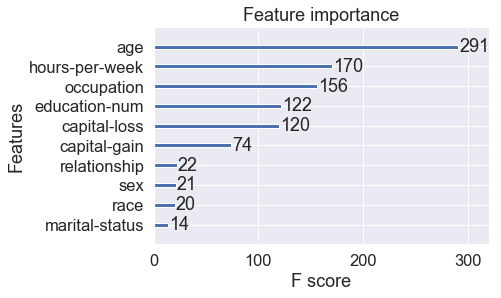

In [52]:
# Find the importance of the different attributes on the salaryclass. 
sns.set(font_scale = 1.5)
xgb.plot_importance(xgbst)